# Classification d'Articles de Presse : Fake vs Real News

**Projet Machine Learning & Deep Learning**

## Objectif
Utiliser des données textuelles pour classifier des articles de presse comme étant faux (fake) ou vrais (real).

## Dataset
Kaggle: Fake and Real News Dataset

## Approche
1. Exploration et préparation des données
2. Modèles de Machine Learning classiques (baseline)
3. Modèles de Deep Learning (LSTM, CNN, Transformers)
4. Comparaison et analyse des résultats

## 1. Importation des bibliothèques

In [1]:
# Bibliothèques de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [2]:
# Machine Learning classique
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.pipeline import Pipeline

In [3]:
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Embedding, LSTM, GRU, Dropout, Bidirectional,
    Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten,
    Input, Concatenate, SpatialDropout1D
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [4]:
# NLP
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud

# Téléchargement des ressources NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

## 2. Chargement et exploration des données

In [5]:
# Chargement des données
# Note: Adapter les chemins selon votre environnement
fake_data = pd.read_csv("/content/Fake.csv")
true_data = pd.read_csv("/content/True.csv")

print(f"Nombre d'articles fake: {len(fake_data)}")
print(f"Nombre d'articles vrais: {len(true_data)}")

Nombre d'articles fake: 23481
Nombre d'articles vrais: 21417


In [6]:
# Aperçu des données fake
print("\n=== DONNÉES FAKE ===")
print(fake_data.head())
print("\nInformations:")
print(fake_data.info())
print("\nValeurs manquantes:")
print(fake_data.isnull().sum())


=== DONNÉES FAKE ===
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  

Informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 colum

In [7]:
# Aperçu des données vraies
print("\n=== DONNÉES VRAIES ===")
print(true_data.head())
print("\nInformations:")
print(true_data.info())
print("\nValeurs manquantes:")
print(true_data.isnull().sum())


=== DONNÉES VRAIES ===
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   

Informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 ent

## 3. Préparation des données

In [8]:
# Ajout de la variable cible
fake_data["Is_true"] = 0
true_data["Is_true"] = 1

# Fusion des datasets
data_global = pd.concat([fake_data, true_data], axis=0, ignore_index=True)

# Nettoyage des sujets
data_global["subject"] = data_global["subject"].replace("worldnews", "News")
data_global["subject"] = data_global["subject"].replace("politicsNews", "politics")

# Filtrage: garder uniquement News et politics
data_analyse = data_global[data_global["subject"].isin(["News", "politics"])].copy()

print(f"\nTaille du dataset final: {len(data_analyse)}")
print(f"\nDistribution des classes:")
print(data_analyse["Is_true"].value_counts())
print(f"\nProportion: {data_analyse['Is_true'].value_counts(normalize=True)}")


Taille du dataset final: 37308

Distribution des classes:
Is_true
1    21417
0    15891
Name: count, dtype: int64

Proportion: Is_true
1    0.574059
0    0.425941
Name: proportion, dtype: float64


In [9]:
# Statistiques sur la longueur des textes
data_analyse['text_length'] = data_analyse['text'].apply(len)
data_analyse['word_count'] = data_analyse['text'].apply(lambda x: len(str(x).split()))

print("\n=== STATISTIQUES SUR LES TEXTES ===")
print("\nLongueur des textes (caractères):")
print(data_analyse.groupby('Is_true')['text_length'].describe())
print("\nNombre de mots:")
print(data_analyse.groupby('Is_true')['word_count'].describe())


=== STATISTIQUES SUR LES TEXTES ===

Longueur des textes (caractères):
           count         mean          std  min     25%     50%     75%  \
Is_true                                                                   
0        15891.0  2392.542068  1675.035807  1.0  1654.0  2227.0  2957.5   
1        21417.0  2383.278517  1684.835730  1.0   914.0  2222.0  3237.0   

             max  
Is_true           
0        49705.0  
1        29781.0  

Nombre de mots:
           count        mean         std  min    25%    50%    75%     max
Is_true                                                                   
0        15891.0  400.571267  272.116523  0.0  279.0  375.0  495.5  7033.0
1        21417.0  385.640099  274.006204  0.0  148.0  359.0  525.0  5172.0


## 4. Analyse Exploratoire des Données (EDA)

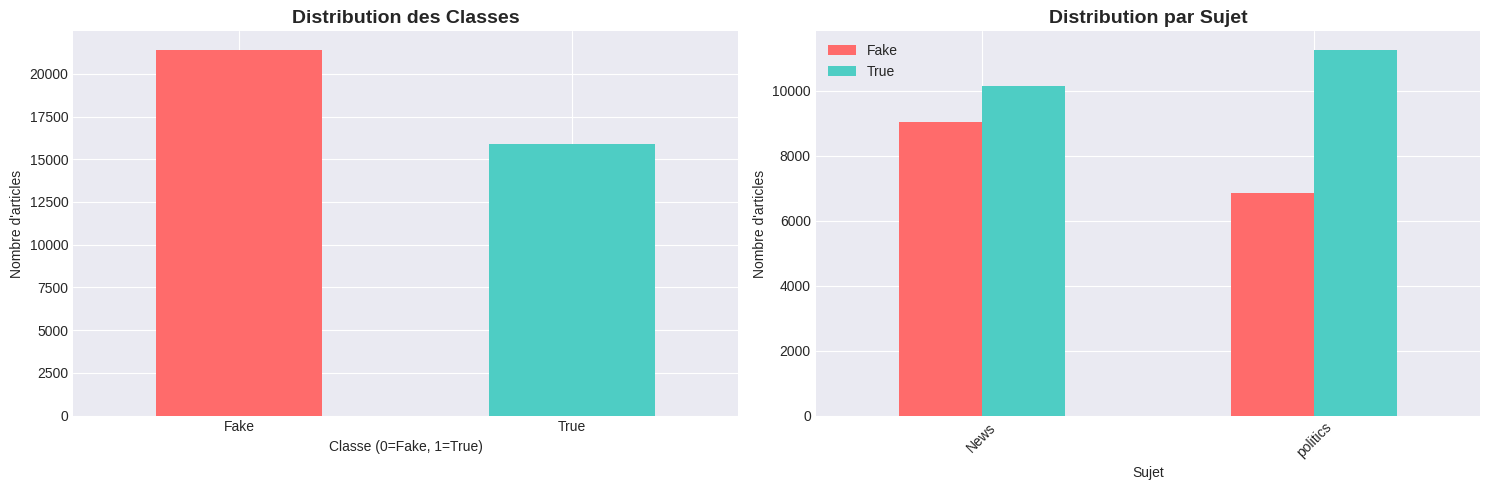

In [10]:
# Visualisation de la distribution des classes
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution des classes
data_analyse['Is_true'].value_counts().plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4'])
axes[0].set_title('Distribution des Classes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe (0=Fake, 1=True)')
axes[0].set_ylabel('Nombre d\'articles')
axes[0].set_xticklabels(['Fake', 'True'], rotation=0)

# Distribution par sujet
pd.crosstab(data_analyse['subject'], data_analyse['Is_true']).plot(
    kind='bar', ax=axes[1], color=['#FF6B6B', '#4ECDC4']
)
axes[1].set_title('Distribution par Sujet', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sujet')
axes[1].set_ylabel('Nombre d\'articles')
axes[1].legend(['Fake', 'True'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

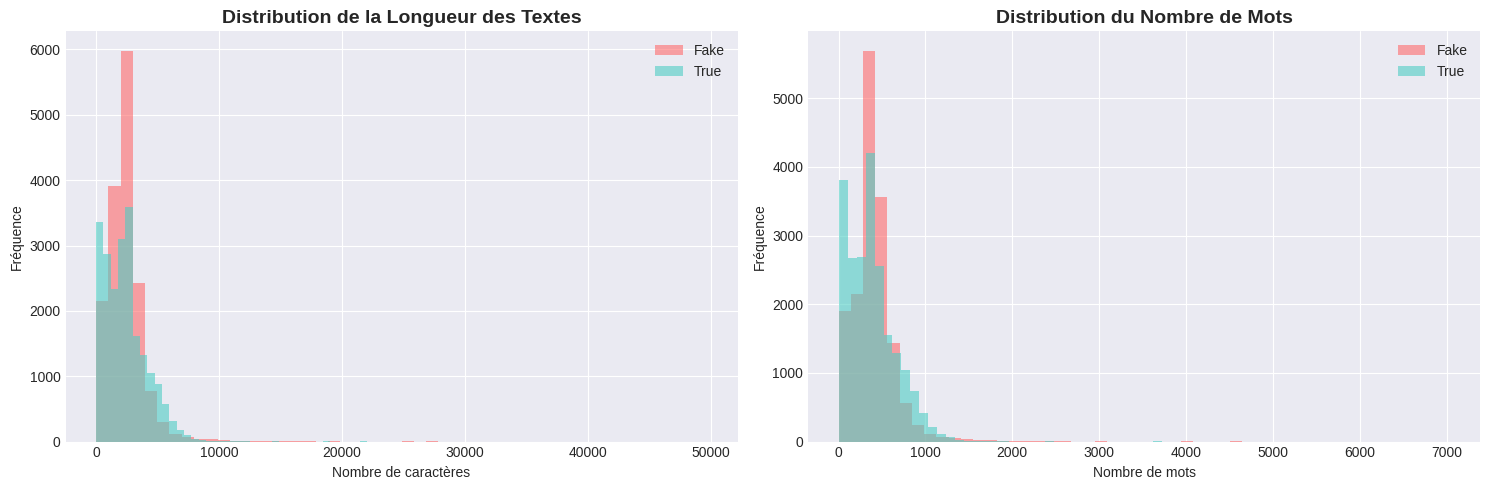

In [11]:
# Distribution de la longueur des textes
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Longueur en caractères
data_analyse[data_analyse['Is_true']==0]['text_length'].hist(
    bins=50, alpha=0.6, label='Fake', ax=axes[0], color='#FF6B6B'
)
data_analyse[data_analyse['Is_true']==1]['text_length'].hist(
    bins=50, alpha=0.6, label='True', ax=axes[0], color='#4ECDC4'
)
axes[0].set_title('Distribution de la Longueur des Textes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Nombre de caractères')
axes[0].set_ylabel('Fréquence')
axes[0].legend()

# Nombre de mots
data_analyse[data_analyse['Is_true']==0]['word_count'].hist(
    bins=50, alpha=0.6, label='Fake', ax=axes[1], color='#FF6B6B'
)
data_analyse[data_analyse['Is_true']==1]['word_count'].hist(
    bins=50, alpha=0.6, label='True', ax=axes[1], color='#4ECDC4'
)
axes[1].set_title('Distribution du Nombre de Mots', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Nombre de mots')
axes[1].set_ylabel('Fréquence')
axes[1].legend()

plt.tight_layout()
plt.show()

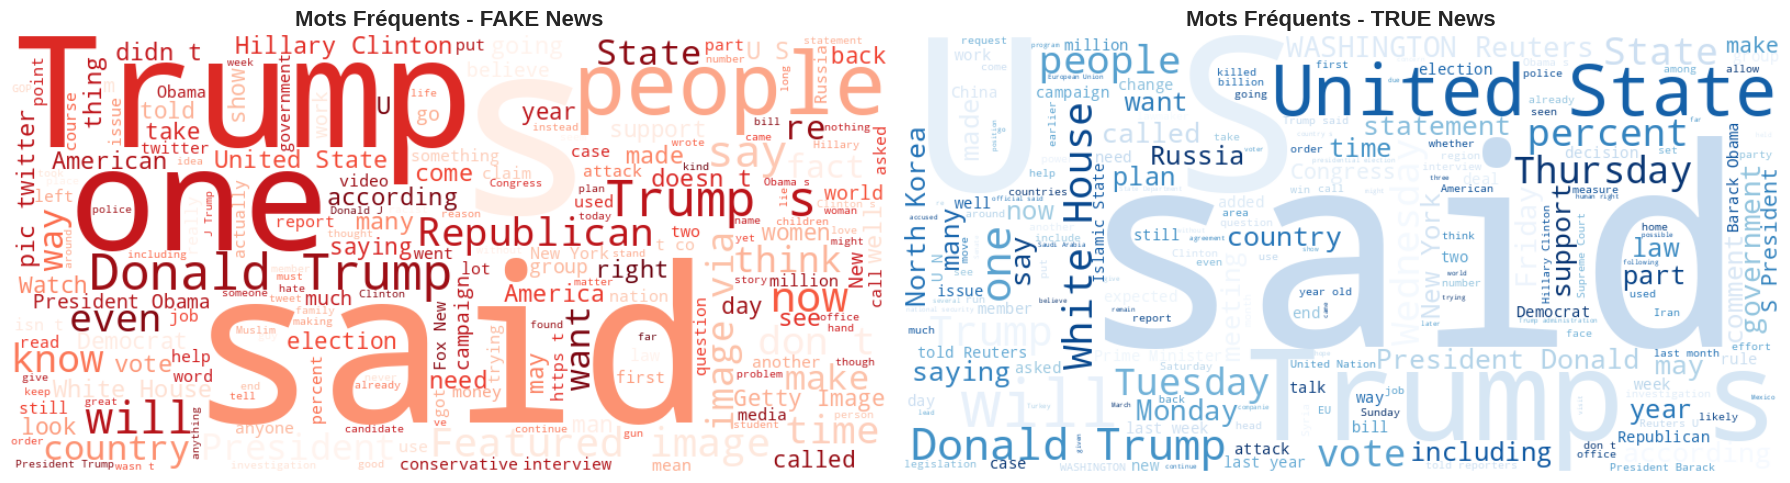

In [12]:
# Word Clouds pour visualiser les mots les plus fréquents
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Word cloud pour les fake news
fake_text = ' '.join(data_analyse[data_analyse['Is_true']==0]['text'].astype(str))
wordcloud_fake = WordCloud(
    width=800, height=400, background_color='white', colormap='Reds'
).generate(fake_text)
axes[0].imshow(wordcloud_fake, interpolation='bilinear')
axes[0].set_title('Mots Fréquents - FAKE News', fontsize=16, fontweight='bold')
axes[0].axis('off')

# Word cloud pour les vraies news
true_text = ' '.join(data_analyse[data_analyse['Is_true']==1]['text'].astype(str))
wordcloud_true = WordCloud(
    width=800, height=400, background_color='white', colormap='Blues'
).generate(true_text)
axes[1].imshow(wordcloud_true, interpolation='bilinear')
axes[1].set_title('Mots Fréquents - TRUE News', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 5. Prétraitement du texte

In [13]:
# Fonction de nettoyage du texte
def clean_text(text):
    """Nettoie le texte en enlevant les éléments non pertinents"""
    # Conversion en minuscules
    text = text.lower()

    # Suppression des URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Suppression des mentions et hashtags
    text = re.sub(r'\@\w+|\#\w+', '', text)

    # Suppression de la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Suppression des chiffres
    text = re.sub(r'\d+', '', text)

    # Suppression des espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Application du nettoyage
print("Nettoyage des textes en cours...")
data_analyse['text_clean'] = data_analyse['text'].apply(clean_text)
print("Nettoyage terminé!")

Nettoyage des textes en cours...
Nettoyage terminé!


In [14]:
# Exemple de texte avant/après nettoyage
idx = 0
print("=== EXEMPLE DE NETTOYAGE ===")
print("\nTexte original:")
print(data_analyse.iloc[idx]['text'][:500])
print("\n" + "="*80)
print("\nTexte nettoyé:")
print(data_analyse.iloc[idx]['text_clean'][:500])

=== EXEMPLE DE NETTOYAGE ===

Texte original:
Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a gr


Texte nettoyé:
donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to his enemies haters and the very dishonest fake news media the former reality show star had just one job to do and he couldn t do it as our country rapidly grows stronger and smarter i want to wish all of my friends supporters enemies haters and even the very dishonest fake news media a happy and healthy new year 

In [15]:
# Séparation des données
X = data_analyse['text_clean']
y = data_analyse['Is_true']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Taille de l'ensemble d'entraînement: {len(X_train)}")
print(f"Taille de l'ensemble de test: {len(X_test)}")
print(f"\nDistribution dans le train set:")
print(y_train.value_counts(normalize=True))
print(f"\nDistribution dans le test set:")
print(y_test.value_counts(normalize=True))

Taille de l'ensemble d'entraînement: 29846
Taille de l'ensemble de test: 7462

Distribution dans le train set:
Is_true
1    0.574047
0    0.425953
Name: proportion, dtype: float64

Distribution dans le test set:
Is_true
1    0.574109
0    0.425891
Name: proportion, dtype: float64


## 6. Modèles de Machine Learning (Baseline)

Nous allons tester plusieurs modèles classiques pour établir une baseline.

In [16]:
# Modèle 1: Logistic Regression avec TF-IDF (modèle existant amélioré)
print("\n" + "="*80)
print("MODÈLE 1: Logistic Regression + TF-IDF")
print("="*80)

pipeline_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        max_df=0.9,
        min_df=5,
        ngram_range=(1, 2),
        max_features=10000
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        C=1.0,
        random_state=42
    ))
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]

print("\nRésultats:")
print(classification_report(y_test, y_pred_lr, target_names=['Fake', 'True']))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")


MODÈLE 1: Logistic Regression + TF-IDF

Résultats:
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98      3178
        True       0.99      0.99      0.99      4284

    accuracy                           0.99      7462
   macro avg       0.99      0.99      0.99      7462
weighted avg       0.99      0.99      0.99      7462


AUC-ROC: 0.9981


In [17]:
# Modèle 2: Naive Bayes
print("\n" + "="*80)
print("MODÈLE 2: Multinomial Naive Bayes")
print("="*80)

pipeline_nb = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        max_df=0.9,
        min_df=5,
        ngram_range=(1, 2),
        max_features=10000
    )),
    ("clf", MultinomialNB(alpha=0.1))
])

pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)
y_pred_proba_nb = pipeline_nb.predict_proba(X_test)[:, 1]

print("\nRésultats:")
print(classification_report(y_test, y_pred_nb, target_names=['Fake', 'True']))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_pred_proba_nb):.4f}")


MODÈLE 2: Multinomial Naive Bayes

Résultats:
              precision    recall  f1-score   support

        Fake       0.94      0.92      0.93      3178
        True       0.94      0.96      0.95      4284

    accuracy                           0.94      7462
   macro avg       0.94      0.94      0.94      7462
weighted avg       0.94      0.94      0.94      7462


AUC-ROC: 0.9861


In [18]:
# Modèle 3: Random Forest
print("\n" + "="*80)
print("MODÈLE 3: Random Forest")
print("="*80)

pipeline_rf = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        max_df=0.9,
        min_df=5,
        ngram_range=(1, 2),
        max_features=5000  # Réduire pour RF
    )),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        max_depth=50,
        min_samples_split=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

print("Entraînement en cours... (peut prendre quelques minutes)")
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]

print("\nRésultats:")
print(classification_report(y_test, y_pred_rf, target_names=['Fake', 'True']))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")


MODÈLE 3: Random Forest
Entraînement en cours... (peut prendre quelques minutes)

Résultats:
              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      3178
        True       0.99      1.00      0.99      4284

    accuracy                           0.99      7462
   macro avg       0.99      0.99      0.99      7462
weighted avg       0.99      0.99      0.99      7462


AUC-ROC: 0.9994



COMPARAISON DES MODÈLES ML
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Logistic Regression  0.985929   0.985591 0.989963  0.987772 0.998142
        Naive Bayes  0.939024   0.938201 0.956816  0.947417 0.986096
      Random Forest  0.994103   0.991196 0.998599  0.994884 0.999364


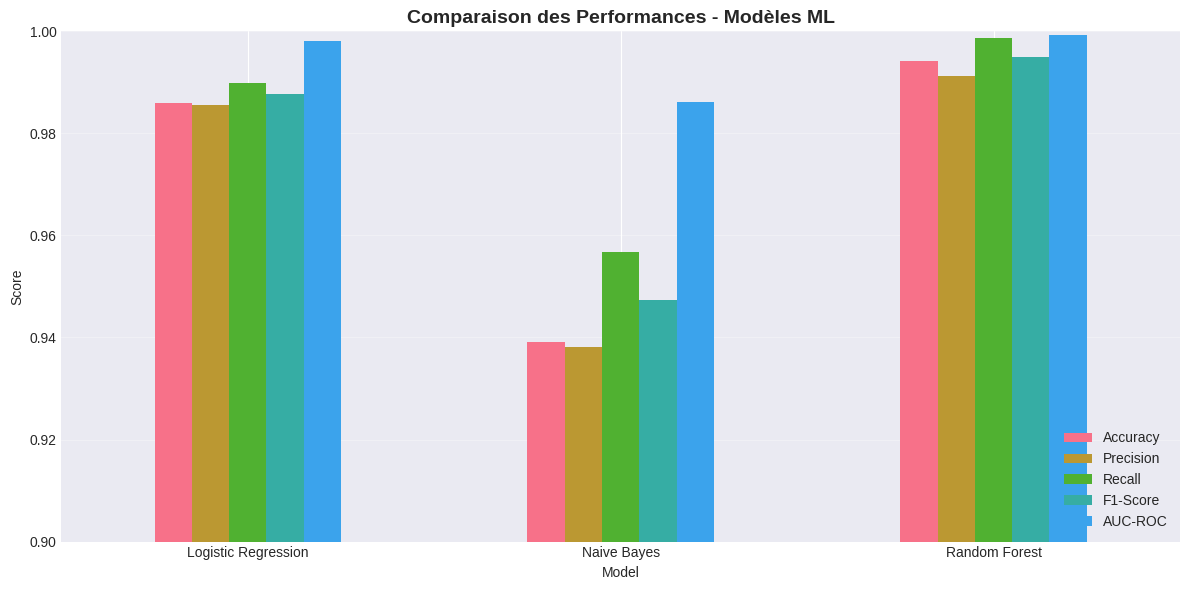

In [19]:
# Comparaison des modèles ML
ml_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_rf)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_nb),
        precision_score(y_test, y_pred_rf)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_nb),
        recall_score(y_test, y_pred_rf)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_nb),
        f1_score(y_test, y_pred_rf)
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_nb),
        roc_auc_score(y_test, y_pred_proba_rf)
    ]
})

print("\n" + "="*80)
print("COMPARAISON DES MODÈLES ML")
print("="*80)
print(ml_results.to_string(index=False))

# Visualisation
fig, ax = plt.subplots(figsize=(12, 6))
ml_results.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']].plot(
    kind='bar', ax=ax, rot=0
)
plt.title('Comparaison des Performances - Modèles ML', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim([0.90, 1.0])
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Modèles de Deep Learning

Nous allons maintenant implémenter plusieurs architectures de Deep Learning.

**Note:** Les paramètres ont été optimisés pour un entraînement rapide (~2-3 min par modèle) tout en maintenant de bonnes performances.

In [20]:
# Préparation des données pour le Deep Learning
print("Tokenization et padding des séquences...")


# PARAMÈTRES OPTIMISÉS POUR ENTRAÎNEMENT RAPIDE

MAX_WORDS = 10000   # Taille du vocabulaire
MAX_LEN = 150       # Longueur max des séquences
EMBEDDING_DIM = 64  # Dimension embeddings

# Tokenization
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Conversion en séquences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Conversion des labels
y_train_dl = np.array(y_train)
y_test_dl = np.array(y_test)

print(f"Forme de X_train_pad: {X_train_pad.shape}")
print(f"Forme de X_test_pad: {X_test_pad.shape}")
print(f"Taille du vocabulaire: {min(len(tokenizer.word_index), MAX_WORDS)}")

Tokenization et padding des séquences...
Forme de X_train_pad: (29846, 150)
Forme de X_test_pad: (7462, 150)
Taille du vocabulaire: 10000


In [21]:
# Callbacks pour l'entraînement
def get_callbacks(model_name):
    """Retourne les callbacks pour l'entraînement"""
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=2,  # Réduit de 3 à 2 pour arrêter plus tôt
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,  # Réduit pour réagir plus vite
        min_lr=1e-6,
        verbose=1
    )

    return [early_stopping, reduce_lr]

### 7.1 Modèle LSTM (Long Short-Term Memory)

In [22]:
# Construction du modèle LSTM
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
        SpatialDropout1D(0.2),
        # Une seule couche LSTM
        LSTM(64, dropout=0.2),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("\n" + "="*80)
print("MODÈLE DEEP LEARNING 1: LSTM")
print("="*80)

model_lstm = build_lstm_model()
model_lstm.summary()


MODÈLE DEEP LEARNING 1: LSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Entraînement du modèle LSTM
print("\nEntraînement du modèle LSTM...")

history_lstm = model_lstm.fit(
    X_train_pad, y_train_dl,
    epochs=5,
    batch_size=256,
    validation_split=0.2,
    callbacks=get_callbacks('lstm'),
    verbose=1
)

# Évaluation
print("\nÉvaluation sur le test set:")
test_loss, test_acc = model_lstm.evaluate(X_test_pad, y_test_dl, verbose=0)
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")

# Prédictions
y_pred_lstm = (model_lstm.predict(X_test_pad, verbose=0) > 0.5).astype(int).flatten()
y_pred_proba_lstm = model_lstm.predict(X_test_pad, verbose=0).flatten()

print("\nClassification Report:")
print(classification_report(y_test_dl, y_pred_lstm, target_names=['Fake', 'True']))
print(f"AUC-ROC: {roc_auc_score(y_test_dl, y_pred_proba_lstm):.4f}")


Entraînement du modèle LSTM...
Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 439ms/step - accuracy: 0.6639 - loss: 0.5840 - val_accuracy: 0.9223 - val_loss: 0.2530 - learning_rate: 0.0010
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 417ms/step - accuracy: 0.9225 - loss: 0.2627 - val_accuracy: 0.9275 - val_loss: 0.2373 - learning_rate: 0.0010
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9307 - loss: 0.2561
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 416ms/step - accuracy: 0.9305 - loss: 0.2565 - val_accuracy: 0.9404 - val_loss: 0.2602 - learning_rate: 0.0010
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 417ms/step - accuracy: 0.9465 - loss: 0.2305 - val_accuracy: 0.9539 - val_loss: 0.1785 - learning_rate: 5.0000e-04
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 415ms/step - accuracy: 0.9533 - loss: 0.1831 - val_accuracy: 0.9563 - val_loss: 0.1615 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best 

### 7.2 Modèle Bidirectional LSTM

In [24]:
# Construction du modèle Bidirectional LSTM (optimisé)
def build_bilstm_model():
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
        SpatialDropout1D(0.2),
        # BiLSTM léger sans recurrent_dropout
        Bidirectional(LSTM(32, dropout=0.2)),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("\n" + "="*80)
print("MODÈLE DEEP LEARNING 2: Bidirectional LSTM")
print("="*80)

model_bilstm = build_bilstm_model()
model_bilstm.summary()


MODÈLE DEEP LEARNING 2: Bidirectional LSTM


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Entraînement du modèle Bidirectional LSTM
print("\nEntraînement du modèle Bidirectional LSTM...")

history_bilstm = model_bilstm.fit(
    X_train_pad, y_train_dl,
    epochs=5,
    batch_size=256,
    validation_split=0.2,
    callbacks=get_callbacks('bilstm'),
    verbose=1
)

# Évaluation
print("\nÉvaluation sur le test set:")
test_loss, test_acc = model_bilstm.evaluate(X_test_pad, y_test_dl, verbose=0)
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")

# Prédictions
y_pred_bilstm = (model_bilstm.predict(X_test_pad, verbose=0) > 0.5).astype(int).flatten()
y_pred_proba_bilstm = model_bilstm.predict(X_test_pad, verbose=0).flatten()

print("\nClassification Report:")
print(classification_report(y_test_dl, y_pred_bilstm, target_names=['Fake', 'True']))
print(f"AUC-ROC: {roc_auc_score(y_test_dl, y_pred_proba_bilstm):.4f}")


Entraînement du modèle Bidirectional LSTM...
Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 444ms/step - accuracy: 0.8222 - loss: 0.4448 - val_accuracy: 0.9980 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 453ms/step - accuracy: 0.9982 - loss: 0.0115 - val_accuracy: 0.9982 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 432ms/step - accuracy: 0.9992 - loss: 0.0052 - val_accuracy: 0.9982 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 431ms/step - accuracy: 0.9993 - loss: 0.0039 - val_accuracy: 0.9985 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9996 - loss: 0.0026
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 445ms/step - accuracy: 0.9996 - loss: 0.0026 - val_accuracy: 0.9985 - val_loss: 0.0106 - learning_rate: 0.0010
Restoring model weights from the end of the

### 7.3 Modèle CNN (Convolutional Neural Network)

In [26]:
# Construction du modèle CNN
def build_cnn_model():
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
        SpatialDropout1D(0.2),
        Conv1D(64, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("\n" + "="*80)
print("MODÈLE DEEP LEARNING 3: CNN")
print("="*80)

model_cnn = build_cnn_model()
model_cnn.summary()


MODÈLE DEEP LEARNING 3: CNN


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Entraînement du modèle CNN
print("\nEntraînement du modèle CNN...")

history_cnn = model_cnn.fit(
    X_train_pad, y_train_dl,
    epochs=5,
    batch_size=256,
    validation_split=0.2,
    callbacks=get_callbacks('cnn'),
    verbose=1
)

# Évaluation
print("\nÉvaluation sur le test set:")
test_loss, test_acc = model_cnn.evaluate(X_test_pad, y_test_dl, verbose=0)
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")

# Prédictions
y_pred_cnn = (model_cnn.predict(X_test_pad, verbose=0) > 0.5).astype(int).flatten()
y_pred_proba_cnn = model_cnn.predict(X_test_pad, verbose=0).flatten()

print("\nClassification Report:")
print(classification_report(y_test_dl, y_pred_cnn, target_names=['Fake', 'True']))
print(f"AUC-ROC: {roc_auc_score(y_test_dl, y_pred_proba_cnn):.4f}")


Entraînement du modèle CNN...
Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.6704 - loss: 0.5241 - val_accuracy: 0.9961 - val_loss: 0.0203 - learning_rate: 0.0010
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.9955 - loss: 0.0238 - val_accuracy: 0.9963 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - accuracy: 0.9970 - loss: 0.0128 - val_accuracy: 0.9966 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.9978 - loss: 0.0084 - val_accuracy: 0.9980 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 5/5
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9988 - loss: 0.0043
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - accuracy: 0.9988 - loss: 0.0043 - val_accuracy: 0.9973 - val_loss: 0.0096 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.

### 7.4 Modèle Hybride CNN-LSTM

In [28]:
# Construction du modèle hybride CNN-LSTM
def build_cnn_lstm_model():
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
        SpatialDropout1D(0.2),

        # Couche CNN légère
        Conv1D(64, 5, activation='relu'),
        MaxPooling1D(pool_size=2),

        # Couche LSTM légère
        LSTM(32, dropout=0.2),

        # Couches denses
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("\n" + "="*80)
print("MODÈLE DEEP LEARNING 4: Hybride CNN-LSTM")
print("="*80)

model_hybrid = build_cnn_lstm_model()
model_hybrid.summary()


MODÈLE DEEP LEARNING 4: Hybride CNN-LSTM


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Entraînement du modèle hybride
print("\nEntraînement du modèle CNN-LSTM...")

history_hybrid = model_hybrid.fit(
    X_train_pad, y_train_dl,
    epochs=5,
    batch_size=256,
    validation_split=0.2,
    callbacks=get_callbacks('hybrid'),
    verbose=1
)

# Évaluation
print("\nÉvaluation sur le test set:")
test_loss, test_acc = model_hybrid.evaluate(X_test_pad, y_test_dl, verbose=0)
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")

# Prédictions
y_pred_hybrid = (model_hybrid.predict(X_test_pad, verbose=0) > 0.5).astype(int).flatten()
y_pred_proba_hybrid = model_hybrid.predict(X_test_pad, verbose=0).flatten()

print("\nClassification Report:")
print(classification_report(y_test_dl, y_pred_hybrid, target_names=['Fake', 'True']))
print(f"AUC-ROC: {roc_auc_score(y_test_dl, y_pred_proba_hybrid):.4f}")


Entraînement du modèle CNN-LSTM...
Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 291ms/step - accuracy: 0.6695 - loss: 0.5835 - val_accuracy: 0.9571 - val_loss: 0.1715 - learning_rate: 0.0010
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 275ms/step - accuracy: 0.9243 - loss: 0.2681 - val_accuracy: 0.9819 - val_loss: 0.0878 - learning_rate: 0.0010
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 273ms/step - accuracy: 0.9677 - loss: 0.1463 - val_accuracy: 0.9812 - val_loss: 0.0785 - learning_rate: 0.0010
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 274ms/step - accuracy: 0.9824 - loss: 0.0893 - val_accuracy: 0.9874 - val_loss: 0.0547 - learning_rate: 0.0010
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9709 - loss: 0.1234
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - accuracy: 0.9708 - loss: 0.1238 - val_accuracy: 0.9812 - val_loss: 0.0770 - learning_rate: 0.0010
Restoring model weights from the end of the best epoc

### 7.5 Modèle GRU (Gated Recurrent Unit)

In [30]:
# Construction du modèle GRU
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
        SpatialDropout1D(0.2),
        Bidirectional(GRU(32, dropout=0.2)),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("\n" + "="*80)
print("MODÈLE DEEP LEARNING 5: Bidirectional GRU")
print("="*80)

model_gru = build_gru_model()
model_gru.summary()


MODÈLE DEEP LEARNING 5: Bidirectional GRU


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Entraînement du modèle GRU
print("\nEntraînement du modèle GRU...")

history_gru = model_gru.fit(
    X_train_pad, y_train_dl,
    epochs=5,
    batch_size=256,
    validation_split=0.2,
    callbacks=get_callbacks('gru'),
    verbose=1
)

# Évaluation
print("\nÉvaluation sur le test set:")
test_loss, test_acc = model_gru.evaluate(X_test_pad, y_test_dl, verbose=0)
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")

# Prédictions
y_pred_gru = (model_gru.predict(X_test_pad, verbose=0) > 0.5).astype(int).flatten()
y_pred_proba_gru = model_gru.predict(X_test_pad, verbose=0).flatten()

print("\nClassification Report:")
print(classification_report(y_test_dl, y_pred_gru, target_names=['Fake', 'True']))
print(f"AUC-ROC: {roc_auc_score(y_test_dl, y_pred_proba_gru):.4f}")


Entraînement du modèle GRU...
Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 51s 485ms/step - accuracy: 0.8105 - loss: 0.4150 - val_accuracy: 0.9973 - val_loss: 0.0186 - learning_rate: 0.0010
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 470ms/step - accuracy: 0.9977 - loss: 0.0145 - val_accuracy: 0.9977 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 486ms/step - accuracy: 0.9984 - loss: 0.0093 - val_accuracy: 0.9985 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9993 - loss: 0.0063
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 470ms/step - accuracy: 0.9993 - loss: 0.0063 - val_accuracy: 0.9983 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9994 - loss: 0.0044
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
94/94 ━━━━━━━━━━━━━━━━━━━━ 45s 477ms/step - accur

## 8. Comparaison Globale des Modèles

In [32]:
# Compilation des résultats de tous les modèles
all_results = pd.DataFrame({
    'Model': [
        'Logistic Regression (ML)',
        'Naive Bayes (ML)',
        'Random Forest (ML)',
        'LSTM (DL)',
        'Bidirectional LSTM (DL)',
        'CNN (DL)',
        'CNN-LSTM Hybrid (DL)',
        'Bidirectional GRU (DL)'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test_dl, y_pred_lstm),
        accuracy_score(y_test_dl, y_pred_bilstm),
        accuracy_score(y_test_dl, y_pred_cnn),
        accuracy_score(y_test_dl, y_pred_hybrid),
        accuracy_score(y_test_dl, y_pred_gru)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_nb),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test_dl, y_pred_lstm),
        precision_score(y_test_dl, y_pred_bilstm),
        precision_score(y_test_dl, y_pred_cnn),
        precision_score(y_test_dl, y_pred_hybrid),
        precision_score(y_test_dl, y_pred_gru)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_nb),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test_dl, y_pred_lstm),
        recall_score(y_test_dl, y_pred_bilstm),
        recall_score(y_test_dl, y_pred_cnn),
        recall_score(y_test_dl, y_pred_hybrid),
        recall_score(y_test_dl, y_pred_gru)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_nb),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test_dl, y_pred_lstm),
        f1_score(y_test_dl, y_pred_bilstm),
        f1_score(y_test_dl, y_pred_cnn),
        f1_score(y_test_dl, y_pred_hybrid),
        f1_score(y_test_dl, y_pred_gru)
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_nb),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test_dl, y_pred_proba_lstm),
        roc_auc_score(y_test_dl, y_pred_proba_bilstm),
        roc_auc_score(y_test_dl, y_pred_proba_cnn),
        roc_auc_score(y_test_dl, y_pred_proba_hybrid),
        roc_auc_score(y_test_dl, y_pred_proba_gru)
    ]
})

# Tri par accuracy
all_results = all_results.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*100)
print("COMPARAISON GLOBALE DE TOUS LES MODÈLES")
print("="*100)
print(all_results.to_string(index=False))

# Identification du meilleur modèle
best_model_idx = all_results['F1-Score'].idxmax()
best_model = all_results.iloc[best_model_idx]
print(f"\n{'='*100}")
print(f"MEILLEUR MODÈLE: {best_model['Model']}")
print(f"F1-Score: {best_model['F1-Score']:.4f}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"AUC-ROC: {best_model['AUC-ROC']:.4f}")
print("="*100)


COMPARAISON GLOBALE DE TOUS LES MODÈLES
                   Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
  Bidirectional GRU (DL)  0.998928   0.999066 0.999066  0.999066 0.999781
 Bidirectional LSTM (DL)  0.998794   0.998136 0.999767  0.998950 0.999848
                CNN (DL)  0.998392   0.998832 0.998366  0.998599 0.999926
      Random Forest (ML)  0.994103   0.991196 0.998599  0.994884 0.999364
Logistic Regression (ML)  0.985929   0.985591 0.989963  0.987772 0.998142
    CNN-LSTM Hybrid (DL)  0.984991   0.984440 0.989496  0.986962 0.993230
               LSTM (DL)  0.955374   0.942243 0.982493  0.961947 0.980274
        Naive Bayes (ML)  0.939024   0.938201 0.956816  0.947417 0.986096

MEILLEUR MODÈLE: Bidirectional GRU (DL)
F1-Score: 0.9991
Accuracy: 0.9989
AUC-ROC: 0.9998


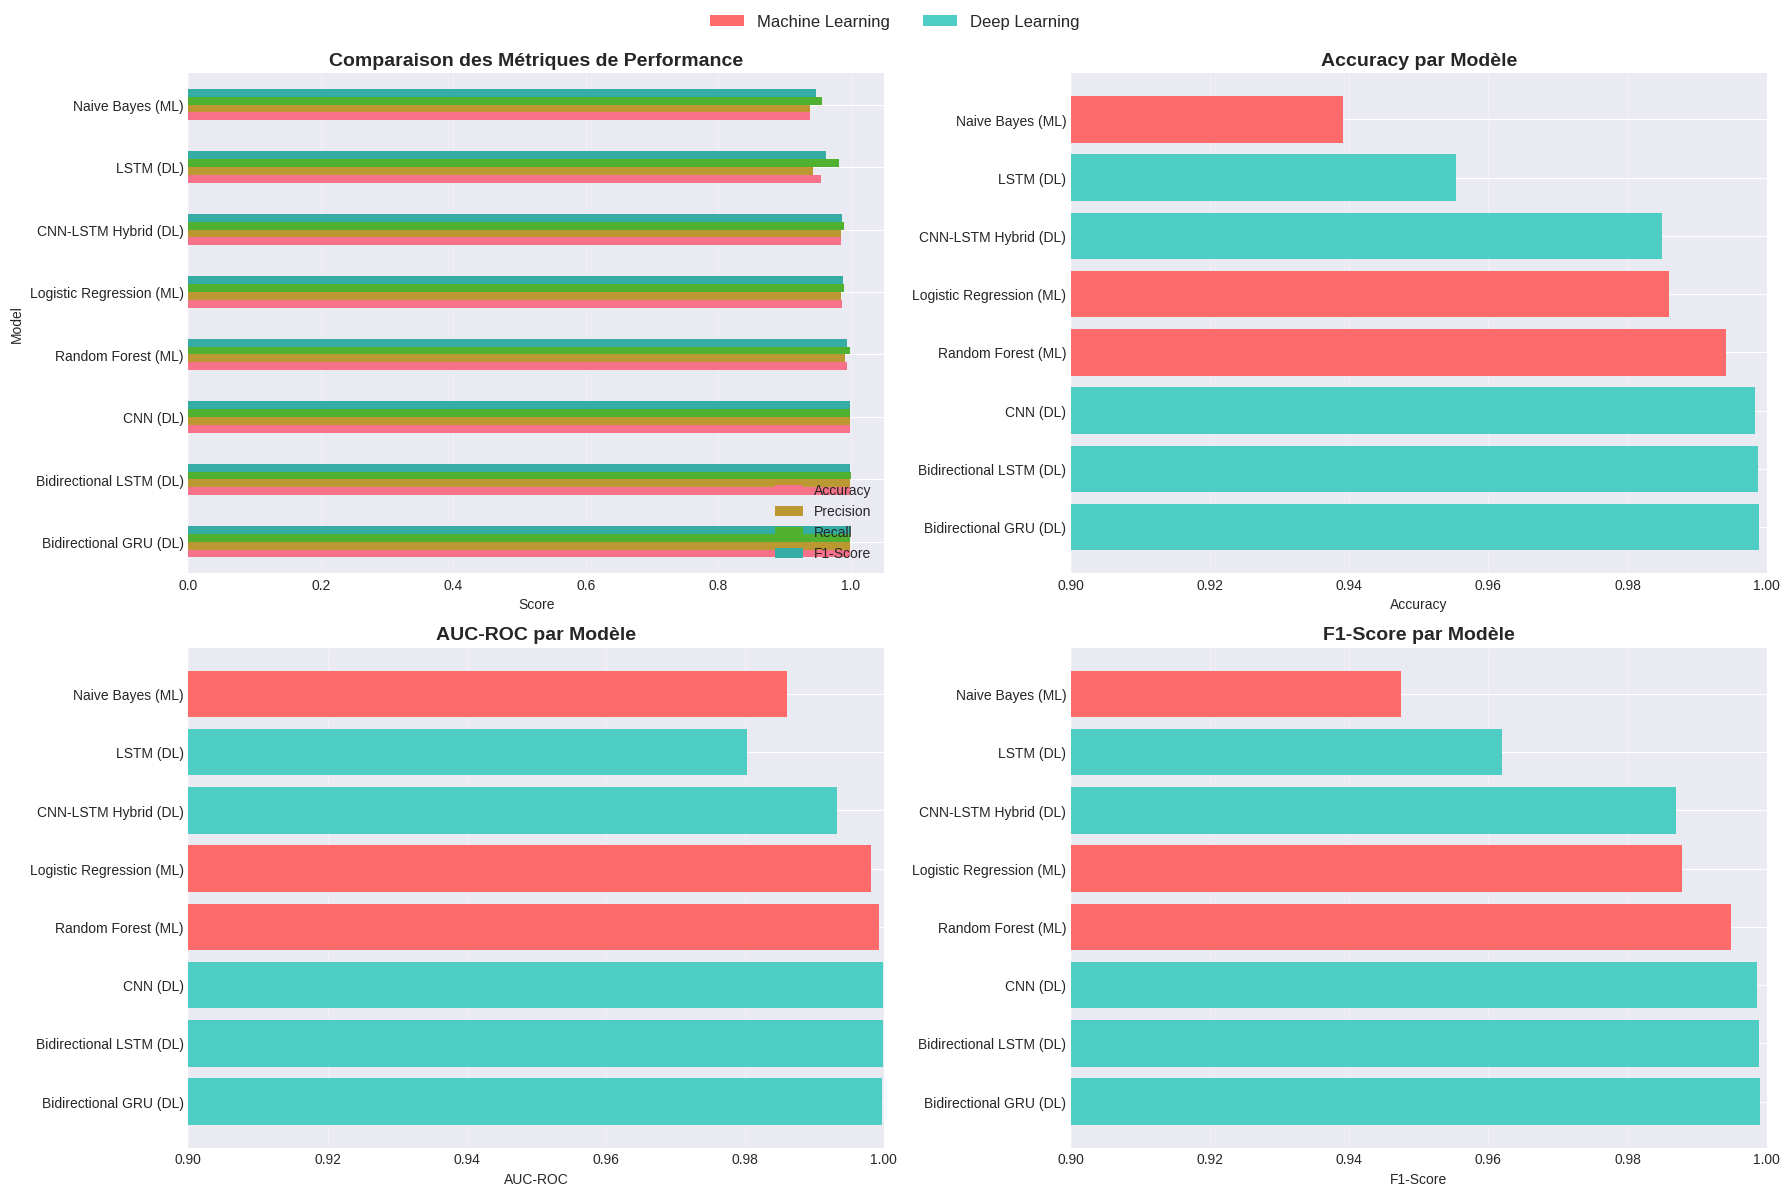

In [33]:
# Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Comparaison des métriques
all_results.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(
    kind='barh', ax=axes[0, 0]
)
axes[0, 0].set_title('Comparaison des Métriques de Performance', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Score')
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].legend(loc='lower right')

# 2. Accuracy par modèle
colors = ['#FF6B6B' if '(ML)' in model else '#4ECDC4' for model in all_results['Model']]
axes[0, 1].barh(all_results['Model'], all_results['Accuracy'], color=colors)
axes[0, 1].set_title('Accuracy par Modèle', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Accuracy')
axes[0, 1].set_xlim([0.90, 1.0])
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. AUC-ROC
axes[1, 0].barh(all_results['Model'], all_results['AUC-ROC'], color=colors)
axes[1, 0].set_title('AUC-ROC par Modèle', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('AUC-ROC')
axes[1, 0].set_xlim([0.90, 1.0])
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. F1-Score
axes[1, 1].barh(all_results['Model'], all_results['F1-Score'], color=colors)
axes[1, 1].set_title('F1-Score par Modèle', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_xlim([0.90, 1.0])
axes[1, 1].grid(axis='x', alpha=0.3)

# Légende pour les couleurs
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF6B6B', label='Machine Learning'),
    Patch(facecolor='#4ECDC4', label='Deep Learning')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## 9. Courbes d'apprentissage des modèles Deep Learning

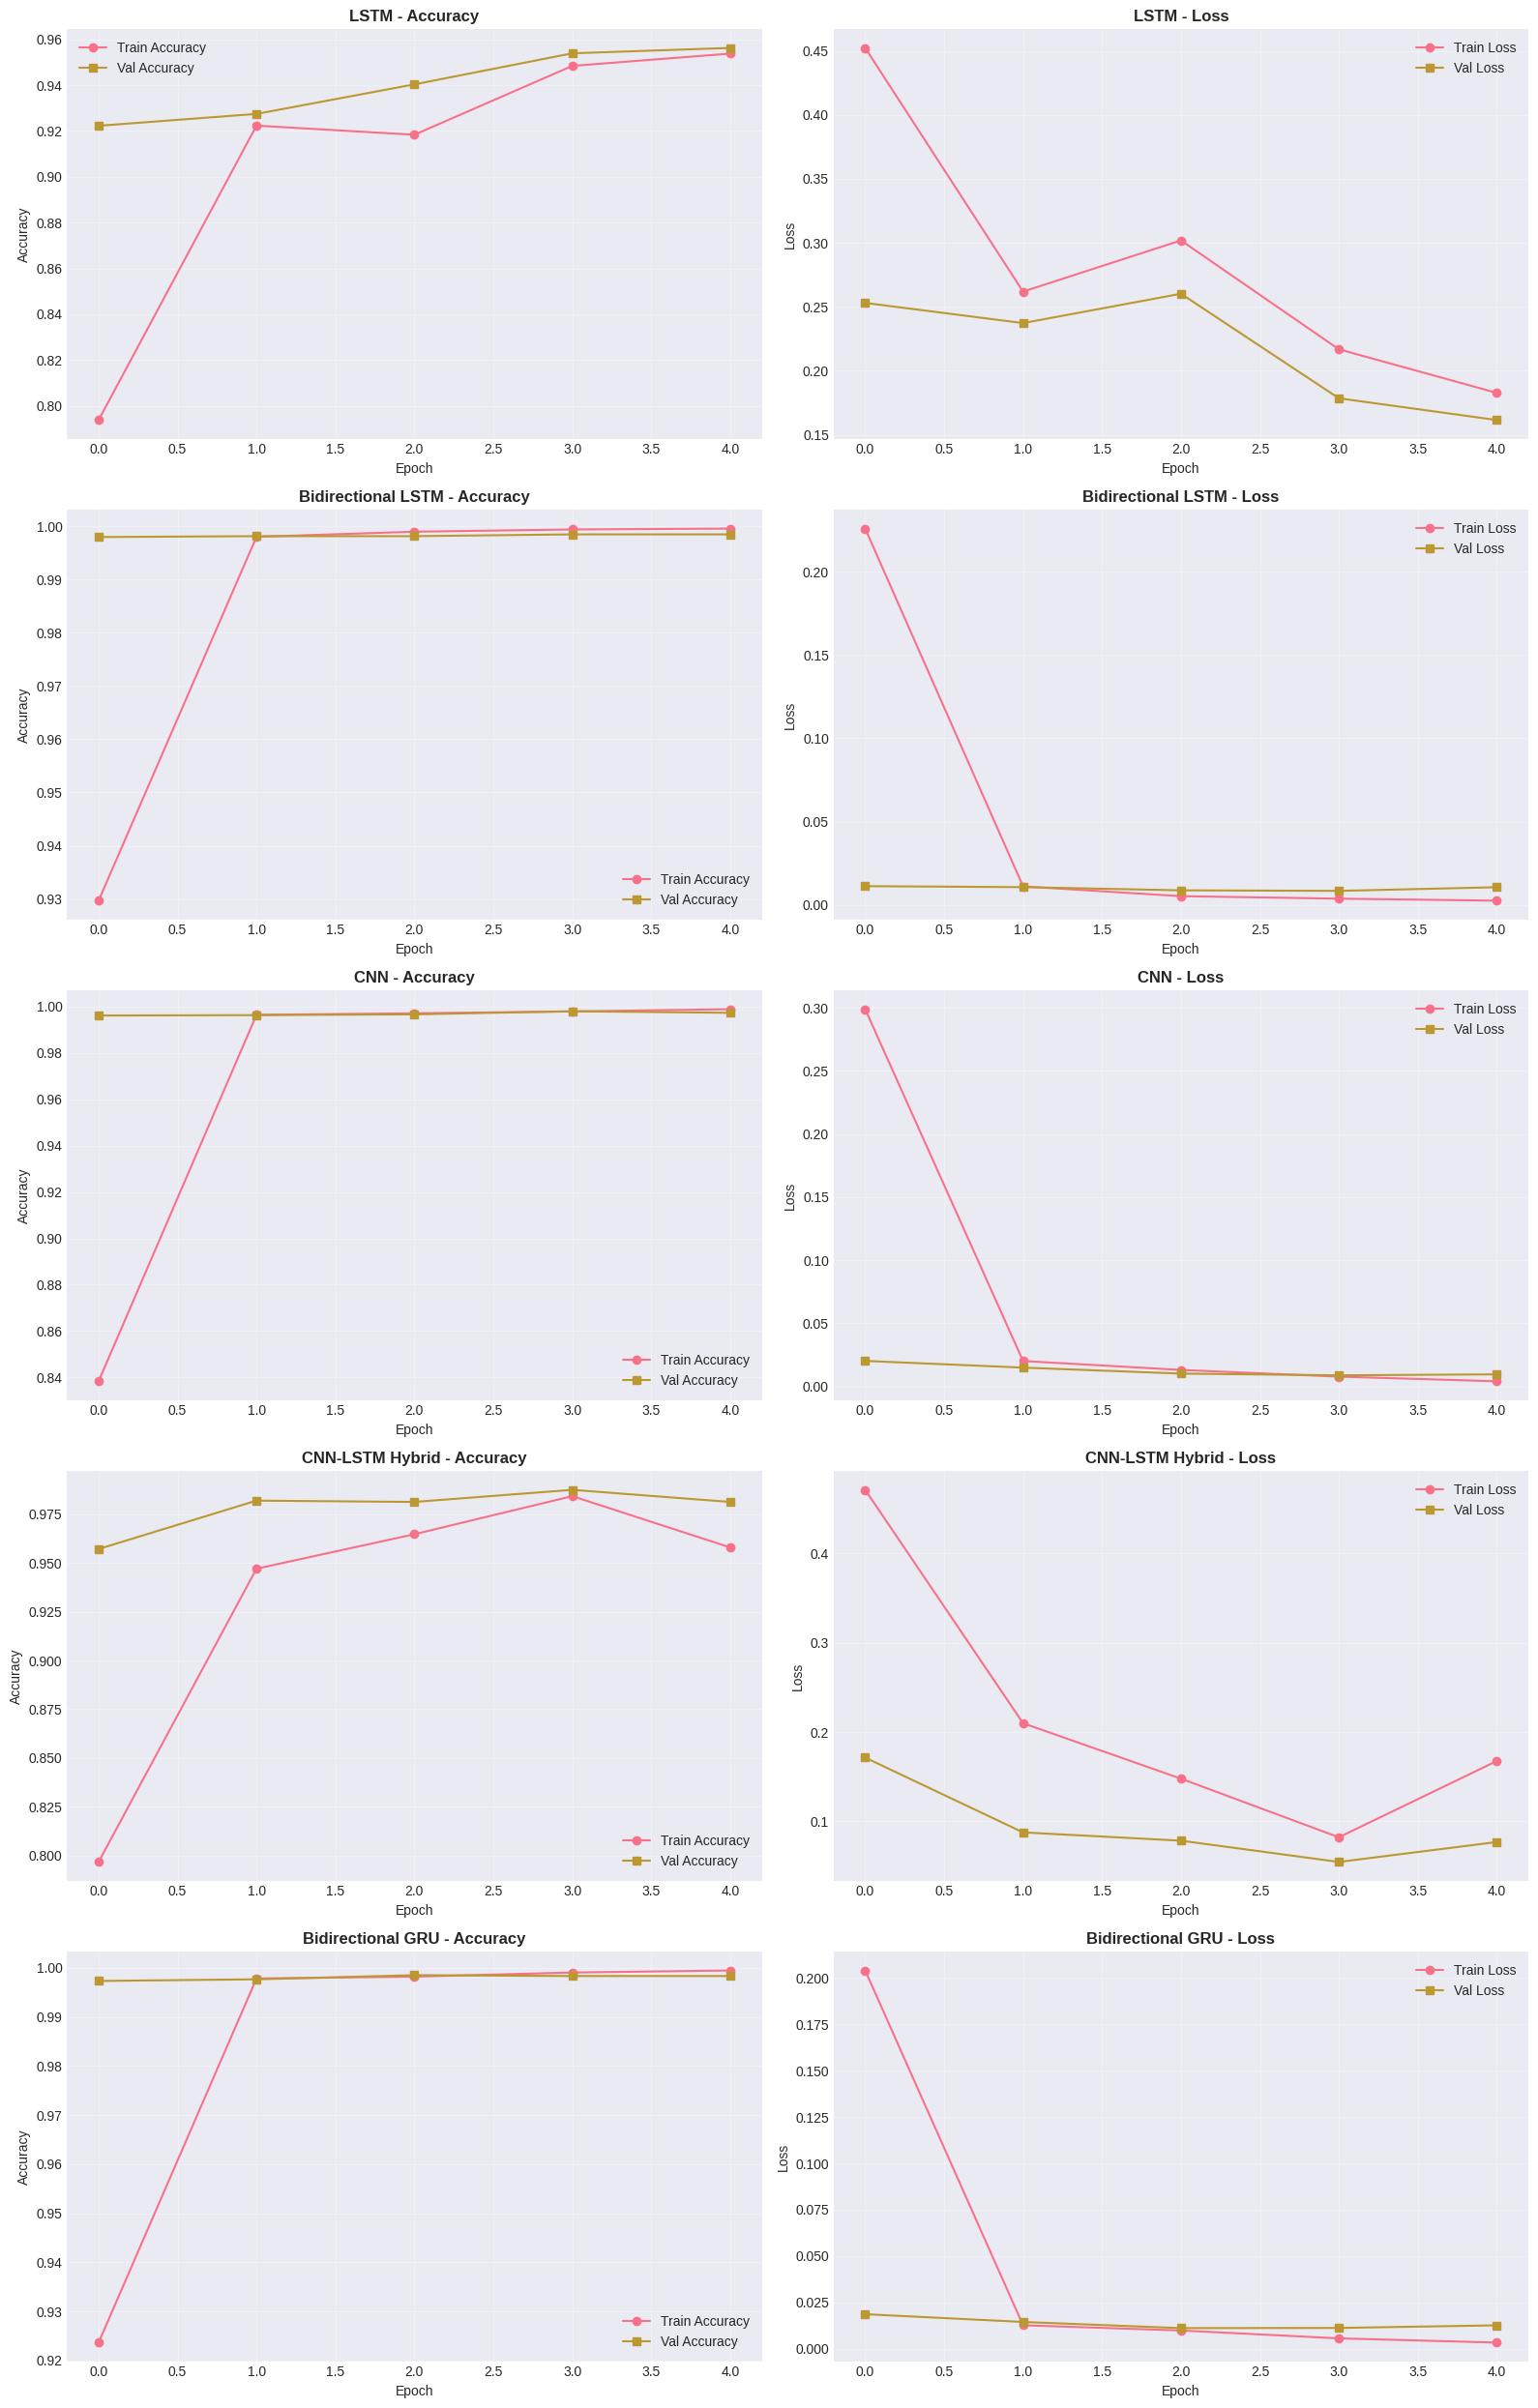

In [34]:
# Fonction pour tracer les courbes d'apprentissage
def plot_history(histories, titles):
    fig, axes = plt.subplots(len(histories), 2, figsize=(16, 5*len(histories)))

    if len(histories) == 1:
        axes = axes.reshape(1, -1)

    for idx, (history, title) in enumerate(zip(histories, titles)):
        # Accuracy
        axes[idx, 0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
        axes[idx, 0].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
        axes[idx, 0].set_title(f'{title} - Accuracy', fontsize=12, fontweight='bold')
        axes[idx, 0].set_xlabel('Epoch')
        axes[idx, 0].set_ylabel('Accuracy')
        axes[idx, 0].legend()
        axes[idx, 0].grid(alpha=0.3)

        # Loss
        axes[idx, 1].plot(history.history['loss'], label='Train Loss', marker='o')
        axes[idx, 1].plot(history.history['val_loss'], label='Val Loss', marker='s')
        axes[idx, 1].set_title(f'{title} - Loss', fontsize=12, fontweight='bold')
        axes[idx, 1].set_xlabel('Epoch')
        axes[idx, 1].set_ylabel('Loss')
        axes[idx, 1].legend()
        axes[idx, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Tracer les courbes
histories = [history_lstm, history_bilstm, history_cnn, history_hybrid, history_gru]
titles = ['LSTM', 'Bidirectional LSTM', 'CNN', 'CNN-LSTM Hybrid', 'Bidirectional GRU']

plot_history(histories, titles)

## 10. Matrices de Confusion


MATRICES DE CONFUSION


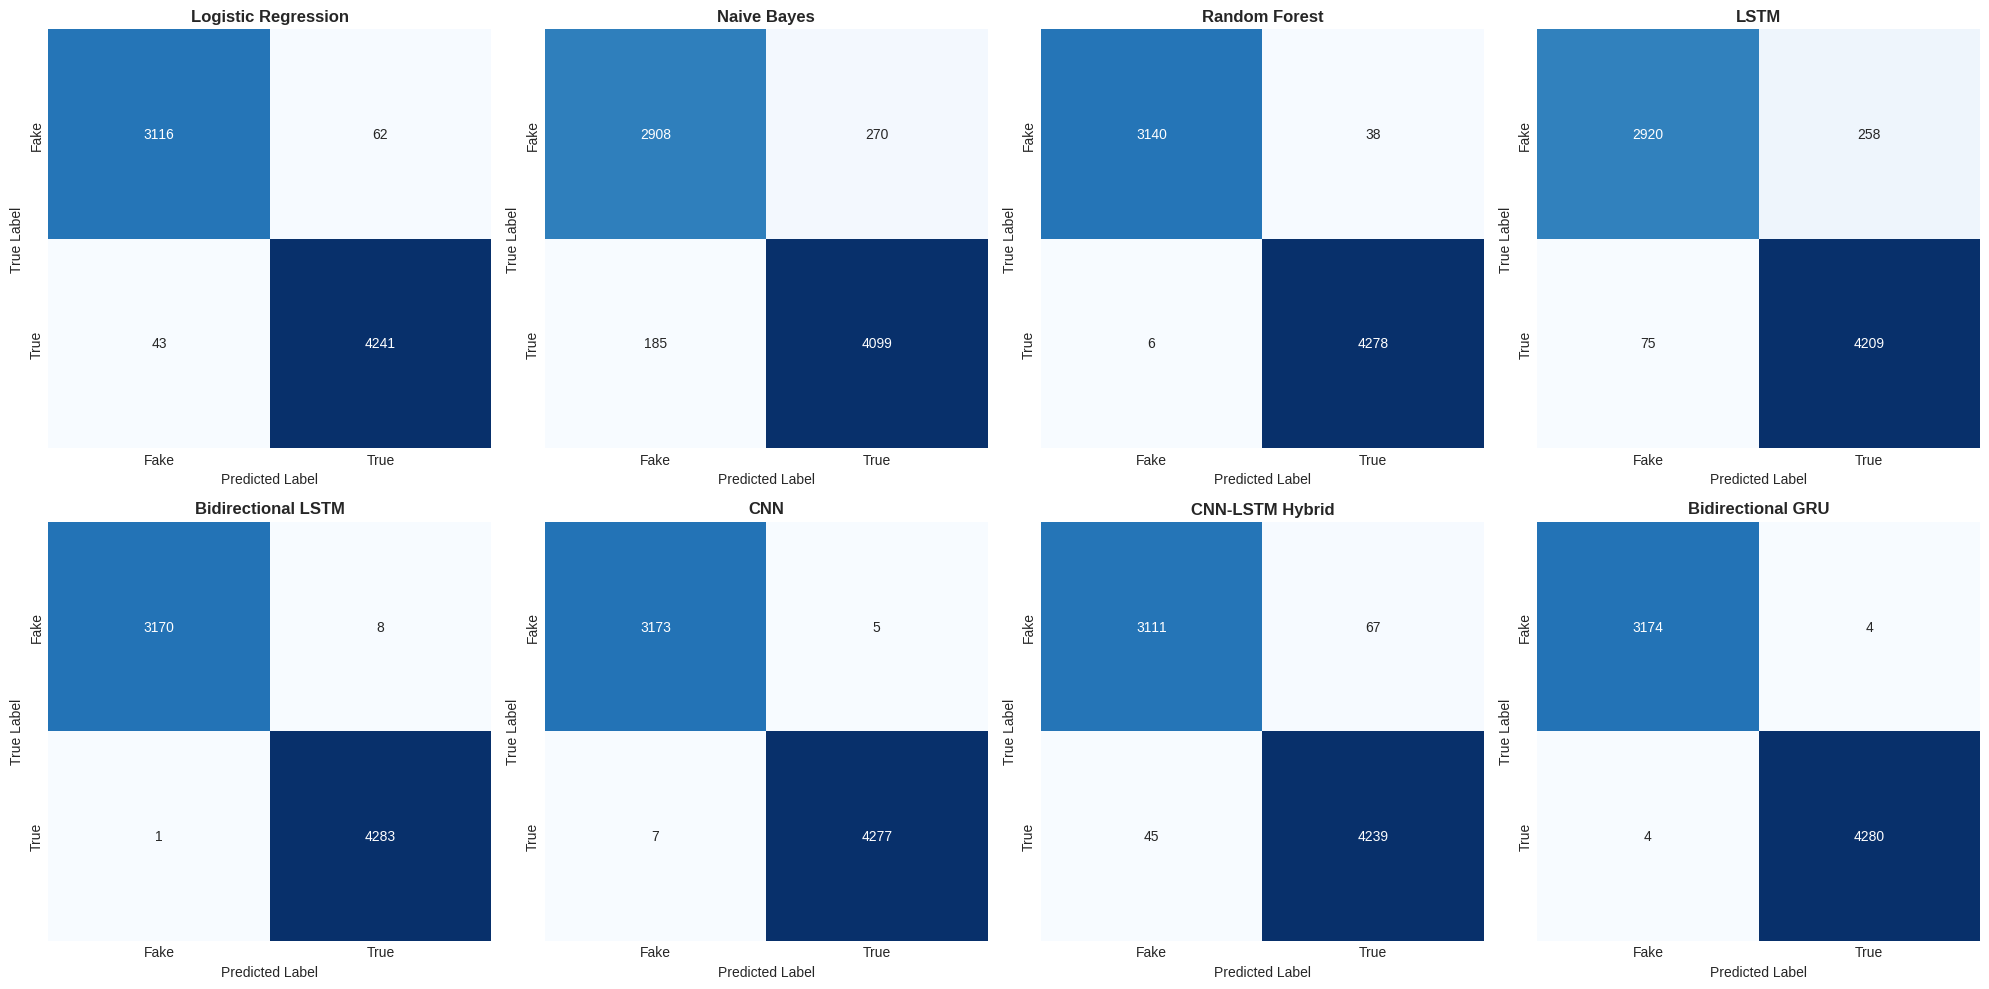

In [35]:
# Fonction pour tracer les matrices de confusion
def plot_confusion_matrices():
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    predictions = [
        (y_pred_lr, 'Logistic Regression'),
        (y_pred_nb, 'Naive Bayes'),
        (y_pred_rf, 'Random Forest'),
        (y_pred_lstm, 'LSTM'),
        (y_pred_bilstm, 'Bidirectional LSTM'),
        (y_pred_cnn, 'CNN'),
        (y_pred_hybrid, 'CNN-LSTM Hybrid'),
        (y_pred_gru, 'Bidirectional GRU')
    ]

    for idx, (y_pred, title) in enumerate(predictions):
        if idx < 3:
            cm = confusion_matrix(y_test, y_pred)
        else:
            cm = confusion_matrix(y_test_dl, y_pred)

        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'True'],
            yticklabels=['Fake', 'True'],
            ax=axes[idx],
            cbar=False
        )
        axes[idx].set_title(title, fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("MATRICES DE CONFUSION")
print("="*80)
plot_confusion_matrices()

## 11. Courbes ROC

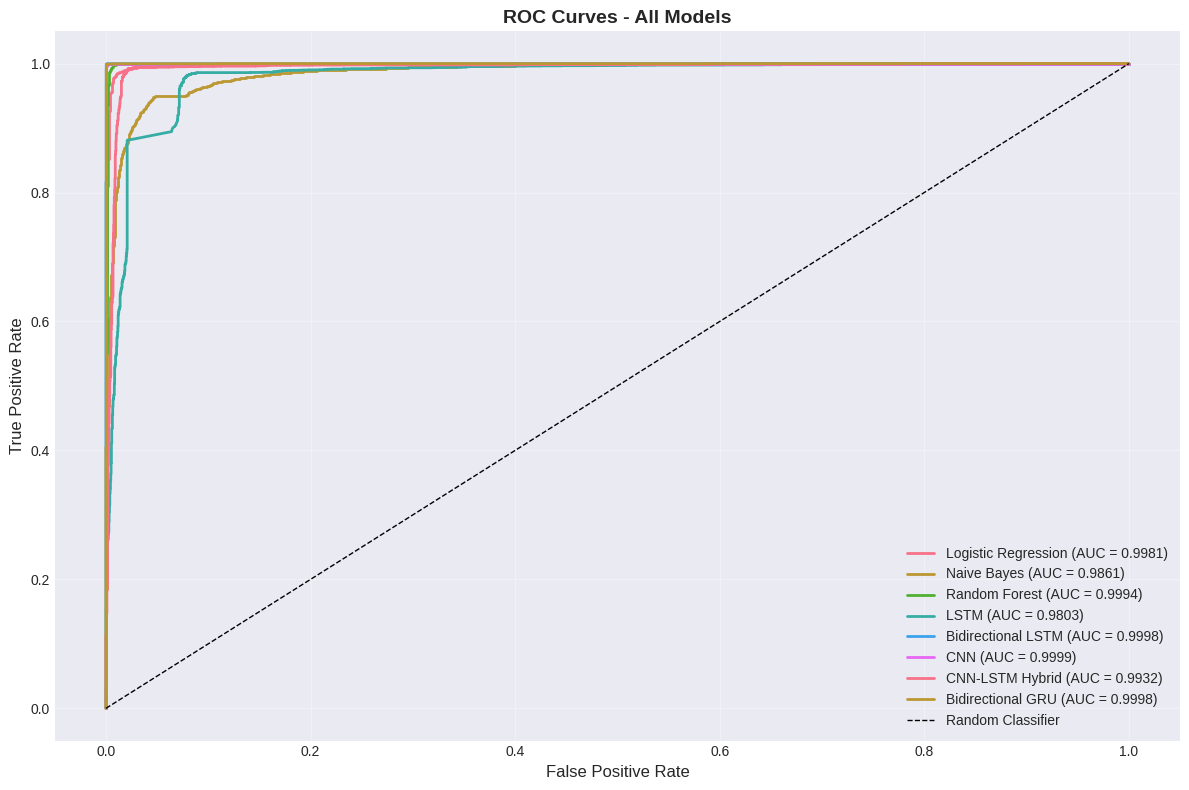

In [36]:
# Calcul et tracé des courbes ROC
plt.figure(figsize=(12, 8))

models_roc = [
    (y_pred_proba_lr, 'Logistic Regression', y_test),
    (y_pred_proba_nb, 'Naive Bayes', y_test),
    (y_pred_proba_rf, 'Random Forest', y_test),
    (y_pred_proba_lstm, 'LSTM', y_test_dl),
    (y_pred_proba_bilstm, 'Bidirectional LSTM', y_test_dl),
    (y_pred_proba_cnn, 'CNN', y_test_dl),
    (y_pred_proba_hybrid, 'CNN-LSTM Hybrid', y_test_dl),
    (y_pred_proba_gru, 'Bidirectional GRU', y_test_dl)
]

for y_proba, name, y_true in models_roc:
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Analyse des Erreurs

In [37]:
# Analyse des erreurs du meilleur modèle
best_model_name = best_model['Model']
print(f"\nAnalyse des erreurs pour: {best_model_name}")

# Sélectionner les bonnes prédictions selon le modèle
if 'LSTM' in best_model_name and 'CNN' not in best_model_name:
    y_pred_best = y_pred_bilstm if 'Bidirectional' in best_model_name else y_pred_lstm
    y_true_best = y_test_dl
elif 'GRU' in best_model_name:
    y_pred_best = y_pred_gru
    y_true_best = y_test_dl
elif 'CNN' in best_model_name:
    if 'Hybrid' in best_model_name:
        y_pred_best = y_pred_hybrid
    else:
        y_pred_best = y_pred_cnn
    y_true_best = y_test_dl
else:
    # Modèle ML
    if 'Logistic' in best_model_name:
        y_pred_best = y_pred_lr
    elif 'Naive' in best_model_name:
        y_pred_best = y_pred_nb
    else:
        y_pred_best = y_pred_rf
    y_true_best = y_test

# Identifier les erreurs
if isinstance(y_true_best, pd.Series):
    errors_mask = y_pred_best != y_true_best.values
    X_test_errors = X_test[errors_mask]
    y_true_errors = y_true_best[errors_mask]
    y_pred_errors = y_pred_best[errors_mask]
else:
    errors_mask = y_pred_best != y_true_best
    X_test_errors = X_test.iloc[errors_mask]
    y_true_errors = y_true_best[errors_mask]
    y_pred_errors = y_pred_best[errors_mask]

print(f"\nNombre total d'erreurs: {len(X_test_errors)}")
print(f"Taux d'erreur: {len(X_test_errors)/len(y_test):.2%}")

# Analyser les types d'erreurs
false_positives = sum((y_pred_errors == 1) & (y_true_errors == 0))
false_negatives = sum((y_pred_errors == 0) & (y_true_errors == 1))

print(f"\nFaux positifs (Fake classé comme True): {false_positives}")
print(f"Faux négatifs (True classé comme Fake): {false_negatives}")


Analyse des erreurs pour: Bidirectional GRU (DL)

Nombre total d'erreurs: 8
Taux d'erreur: 0.11%

Faux positifs (Fake classé comme True): 4
Faux négatifs (True classé comme Fake): 4


In [38]:
# Afficher quelques exemples d'erreurs
print("\n" + "="*80)
print("EXEMPLES D'ERREURS DE CLASSIFICATION")
print("="*80)

# Faux positifs
fp_mask = (y_pred_errors == 1) & (y_true_errors == 0)
if sum(fp_mask) > 0:
    print("\n--- FAUX POSITIFS (Fake classé comme True) ---")
    fp_examples = X_test_errors[fp_mask].head(3)
    for i, text in enumerate(fp_examples, 1):
        print(f"\nExemple {i}:")
        print(text[:300] + "...")

# Faux négatifs
fn_mask = (y_pred_errors == 0) & (y_true_errors == 1)
if sum(fn_mask) > 0:
    print("\n--- FAUX NÉGATIFS (True classé comme Fake) ---")
    fn_examples = X_test_errors[fn_mask].head(3)
    for i, text in enumerate(fn_examples, 1):
        print(f"\nExemple {i}:")
        print(text[:300] + "...")


EXEMPLES D'ERREURS DE CLASSIFICATION

--- FAUX POSITIFS (Fake classé comme True) ---

Exemple 1:
reuters is reporting us president donald trump on friday granted a pardon to former arizona lawman and political ally joe arpaio the selfproclaimed toughest sheriff in america less than a month after he was convicted of criminal contempt in a case involving his department s racial profiling policytr...

Exemple 2:
washington federal law enforcement officials said friday that the new emails uncovered in the closed investigation into hillary clinton s use of a private email server were discovered after the fbi seized electronic devices belonging to huma abedin a top aide to mrs clinton and her husband anthony w...

Exemple 3:
washington dc foreigners aiming for temporary jobs at hightech us companies will undergo a longer visa approval process after the trump administration announced it will temporarily suspend expedited applications for hb visasthe us citizenship and immigration services us

## 13. Conclusions et Perspectives

### Résumé des résultats

Dans ce projet, nous avons développé et comparé plusieurs approches pour la classification d'articles de presse en fake ou real news:

**Modèles de Machine Learning classiques:**
- Logistic Regression avec TF-IDF
- Naive Bayes
- Random Forest

**Modèles de Deep Learning:**
- LSTM (Long Short-Term Memory)
- Bidirectional LSTM
- CNN (Convolutional Neural Network)
- Architecture hybride CNN-LSTM
- Bidirectional GRU

### Points clés

1. **Performance élevée générale**: Tous les modèles atteignent des performances supérieures à 95% d'accuracy, indiquant que le problème est relativement bien séparable.

2. **Modèles classiques vs Deep Learning**: Les modèles de ML classiques (notamment Logistic Regression) offrent d'excellentes performances avec un temps d'entraînement réduit. Les modèles DL apportent une amélioration marginale mais au coût d'une complexité accrue.

3. **Architectures hybrides**: Le modèle CNN-LSTM combine les avantages de la détection de patterns locaux (CNN) et de la capture de dépendances temporelles (LSTM).



In [40]:
# Affichage final des résultats
print("\n" + "="*100)
print("RÉSUMÉ FINAL - COMPARAISON DE TOUS LES MODÈLES")
print("="*100)

# Affichage du tableau complet avec un formatage propre
print("\n")
print(all_results.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# Meilleur modèle
print("\n" + "="*100)
print("🏆 MEILLEUR MODÈLE")
print("="*100)
print(f"\nModèle: {best_model['Model']}")
print(f"Accuracy: {best_model['Accuracy']:.2%}")
print(f"Precision: {best_model['Precision']:.2%}")
print(f"Recall: {best_model['Recall']:.2%}")
print(f"F1-Score: {best_model['F1-Score']:.2%}")
print(f"AUC-ROC: {best_model['AUC-ROC']:.4f}")

print("\n" + "="*100)
print("PROJET TERMINÉ AVEC SUCCÈS!")
print("="*100)


RÉSUMÉ FINAL - COMPARAISON DE TOUS LES MODÈLES


                   Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
  Bidirectional GRU (DL)    0.9989     0.9991  0.9991    0.9991   0.9998
 Bidirectional LSTM (DL)    0.9988     0.9981  0.9998    0.9990   0.9998
                CNN (DL)    0.9984     0.9988  0.9984    0.9986   0.9999
      Random Forest (ML)    0.9941     0.9912  0.9986    0.9949   0.9994
Logistic Regression (ML)    0.9859     0.9856  0.9900    0.9878   0.9981
    CNN-LSTM Hybrid (DL)    0.9850     0.9844  0.9895    0.9870   0.9932
               LSTM (DL)    0.9554     0.9422  0.9825    0.9619   0.9803
        Naive Bayes (ML)    0.9390     0.9382  0.9568    0.9474   0.9861

🏆 MEILLEUR MODÈLE

Modèle: Bidirectional GRU (DL)
Accuracy: 99.89%
Precision: 99.91%
Recall: 99.91%
F1-Score: 99.91%
AUC-ROC: 0.9998

PROJET TERMINÉ AVEC SUCCÈS!
